Using device: cpu


Epochs:: 100%|██████████| 80/80 [00:03<00:00, 22.65it/s]


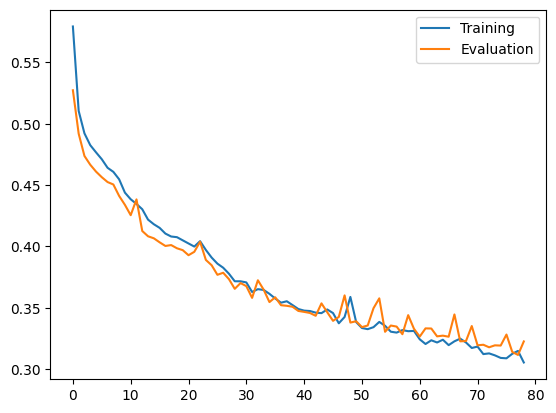

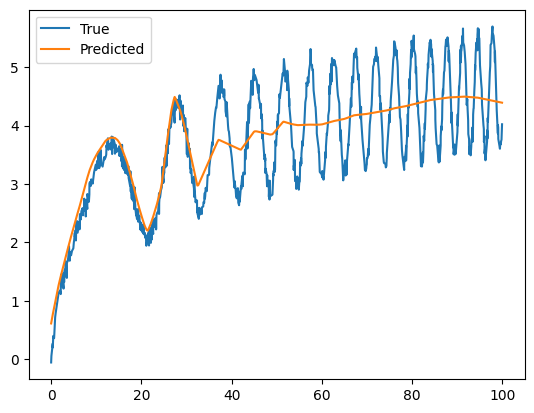

In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

x = np.arange(0,100, 0.01)
noise = np.random.normal(0,100, size=len(x))
np.random.shuffle(x)
# y = x**2+noise
# y = 0.5 * x**3 - 4 * x**2 + x + 10 + noise

# noise = np.random.normal(0,.1, size=len(x))
# y = np.sin(2*np.pi*x/100) + 0.05 * x + noise

# y = np.piecewise(x, [x < 50, x >= 50], [lambda x: x**2, lambda x: np.log(x+1)*20]) +noise

noise = np.random.normal(0,.1, size=len(x))
y = np.sin((x/10)**2) + np.log(x + 1) +noise



x_train, x_rest, y_train, y_rest = train_test_split(x,y, test_size= 0.2, random_state= SEED)
x_eval, x_test, y_eval, y_test = train_test_split(x_rest,y_rest, test_size= 0.5, random_state= SEED)
# x_train = np.arange(0,100, 0.01)
# noise = np.random.normal(0,200, size=len(x_train))
# np.random.shuffle(x_train)
# y0_train = x_train**2
# y_train = y0_train+noise

# plt.figure()
# plt.scatter(x_train, y_train)
# plt.scatter(x_train, y0_train)
# plt.show()

# x_test = np.arange(80,110, 0.01)
# noise = np.random.normal(0,200, size=len(x_test))
# np.random.shuffle(x_test)
# y_test = x_test**2
# y_test = y_test+noise


# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'
print(f"Using device: {device}")

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train.reshape(-1,1))
x_test_scaled = x_scaler.transform(x_test.reshape(-1,1))
x_eval_scaled = x_scaler.transform(x_eval.reshape(-1,1))

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))
y_eval_scaled = y_scaler.transform(y_eval.reshape(-1,1))

x_train_scaled_tensor = torch.tensor(x_train_scaled, dtype= torch.float32, device= device)
x_test_scaled_tensor = torch.tensor(x_test_scaled, dtype= torch.float32, device= device)
x_eval_scaled_tensor = torch.tensor(x_eval_scaled, dtype= torch.float32, device= device)

y_train_scaled_tensor = torch.tensor(y_train_scaled, dtype= torch.float32, device= device)
y_test_scaled_tensor = torch.tensor(y_test_scaled, dtype= torch.float32, device= device)
y_eval_scaled_tensor = torch.tensor(y_eval_scaled, dtype= torch.float32, device= device)

dataset_train = TensorDataset(x_train_scaled_tensor, y_train_scaled_tensor)
dataset_test = TensorDataset(x_test_scaled_tensor, y_test_scaled_tensor)
dataset_eval = TensorDataset(x_eval_scaled_tensor, y_eval_scaled_tensor)
batch_size = 512
dataloader_train = DataLoader(dataset_train, batch_size= batch_size, shuffle= True)
dataloader_test = DataLoader(dataset_test, batch_size= batch_size, shuffle= True)
dataloader_eval = DataLoader(dataset_eval, batch_size= batch_size, shuffle= True)

class MLPModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
        nn.Linear(1,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,1)
    )
    def forward(self, x):
        return self.model(x)

model = MLPModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criteria = torch.nn.MSELoss()
# criteria = torch.nn.L1Loss()
# criteria = torch.nn.SmoothL1Loss()

model.train()
epochs = 80
Total_loss = []
Total_loss_eval = []
for epoch in tqdm(range(epochs), desc= 'Epochs:'):
    model.train()
    loss_epoch = 0
    for xx, yy in dataloader_train:
        y_predicted = model(xx)
        loss = criteria(yy, y_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    Total_loss.append(loss_epoch/len(dataloader_train))
    # print(f"Epoch: {epoch+1}/{epochs} -- MSE: {loss_epoch/len(dataloader_train): .4f}")
    model.eval()
    loss_epoch_eval = 0
    with torch.no_grad():
        for xe, ye in dataloader_eval:
            ye_pred = model(xe)
            loss = criteria(ye_pred, ye)
            loss_epoch_eval += loss.item()

    Total_loss_eval.append(loss_epoch_eval/len(dataloader_eval))



plt.figure()
plt.plot(Total_loss[1:], label = "Training")
plt.plot(Total_loss_eval[1:], label= "Evaluation")
plt.legend()
plt.show()

labels_test = []
labels_predicted = []
xt_test = []
with torch.no_grad():
    for xt, yt in dataloader_test:
        yt_predicted = model(xt)
        loss = criteria(yt, yt_predicted)
        # print(f"MSE of Test: {loss.item()}")
        labels_test.append(yt.cpu().numpy())
        labels_predicted.append(yt_predicted.cpu().numpy())
        xt_test.append(xt.cpu().numpy())
xt_test = np.concatenate(xt_test, axis= 0)
labels_predicted = np.concatenate(labels_predicted, axis= 0)
labels_test = np.concatenate(labels_test, axis= 0)

xt_test = x_scaler.inverse_transform(xt_test)
labels_predicted = y_scaler.inverse_transform(labels_predicted)
labels_test = y_scaler.inverse_transform(labels_test)

index_sorted =np.argsort(xt_test.ravel())
xt_sorted = xt_test[index_sorted]
labels_sorted = labels_test[index_sorted]
labels_predicted_sorted = labels_predicted[index_sorted]


plt.figure()
plt.plot(xt_sorted, labels_sorted, label = "True")
plt.plot(xt_sorted, labels_predicted_sorted, label = "Predicted")
plt.legend()
plt.show()